Loading data...
Dataset shape: (50120, 55)

First few rows:

=== DATASET INFORMATION ===
Number of samples: 50120
Number of features: 54
Target variable: Cover_Type

Data types:
int64    55
Name: count, dtype: int64

Memory usage: 21.03 MB

=== MISSING VALUES ===
✓ No missing values detected

=== TARGET VARIABLE DISTRIBUTION ===
Cover_Type
1    10156
2    28908
3     2160
4     2160
5     2416
6     2160
7     2160
Name: count, dtype: int64

Class balance:
Cover_Type
1    20.26
2    57.68
3     4.31
4     4.31
5     4.82
6     4.31
7     4.31
Name: count, dtype: float64


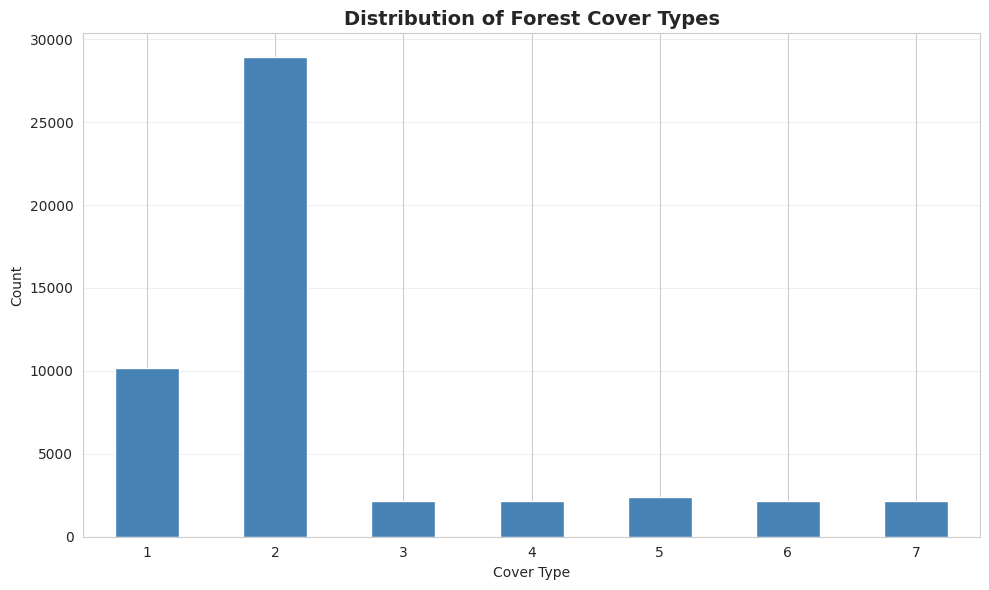


=== FEATURE GROUPS ===
Continuous features: 10
Wilderness area features: 4
Soil type features: 40

=== CONTINUOUS FEATURES SUMMARY ===


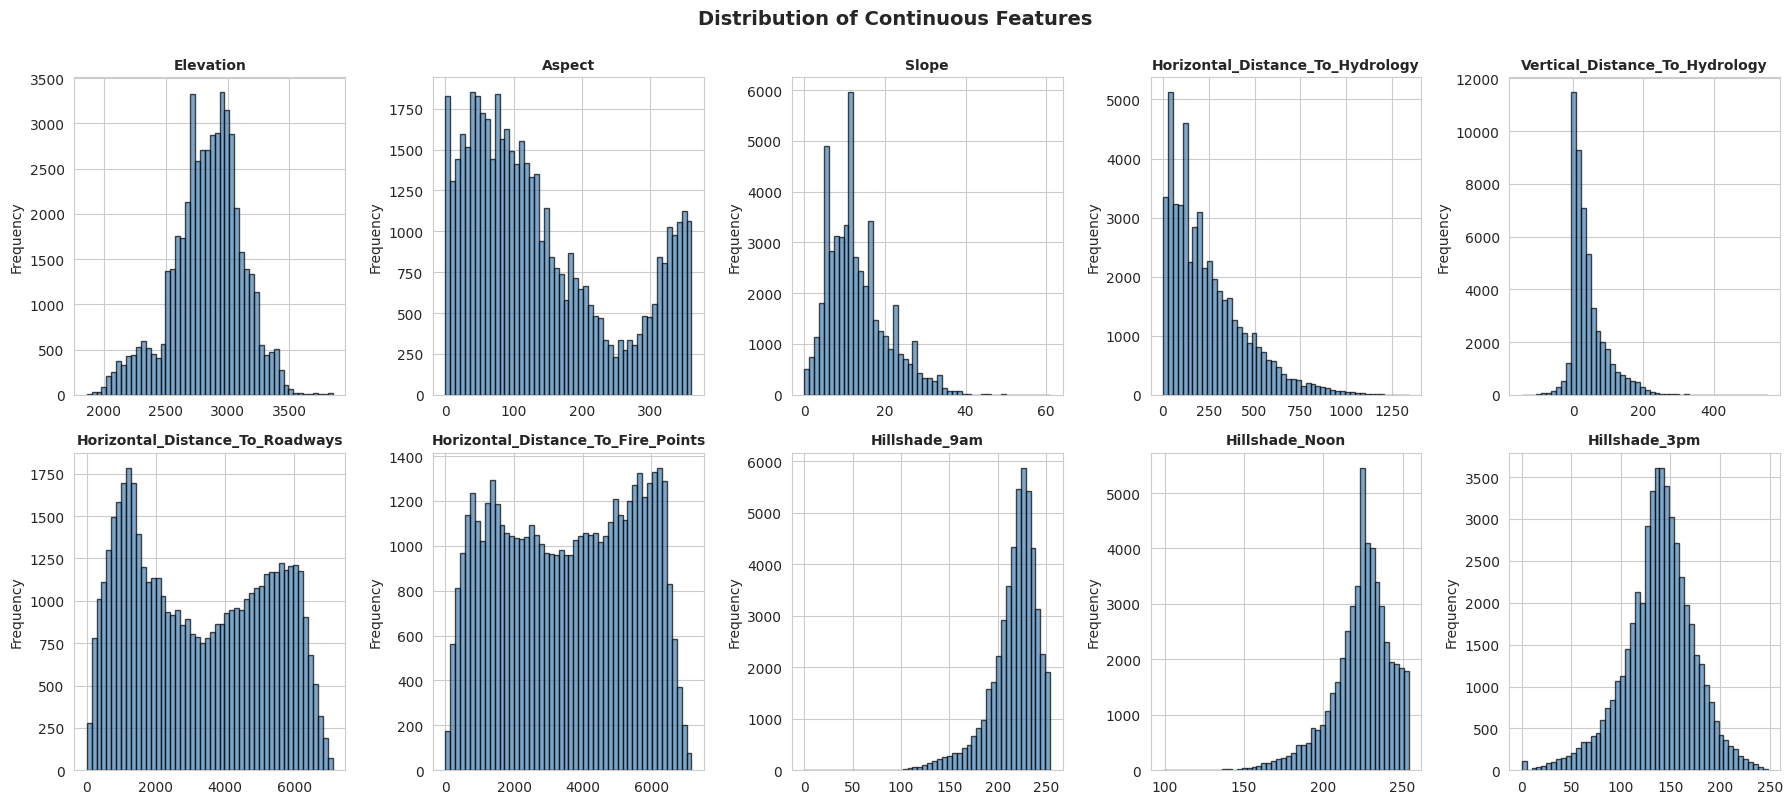


=== CORRELATION ANALYSIS ===


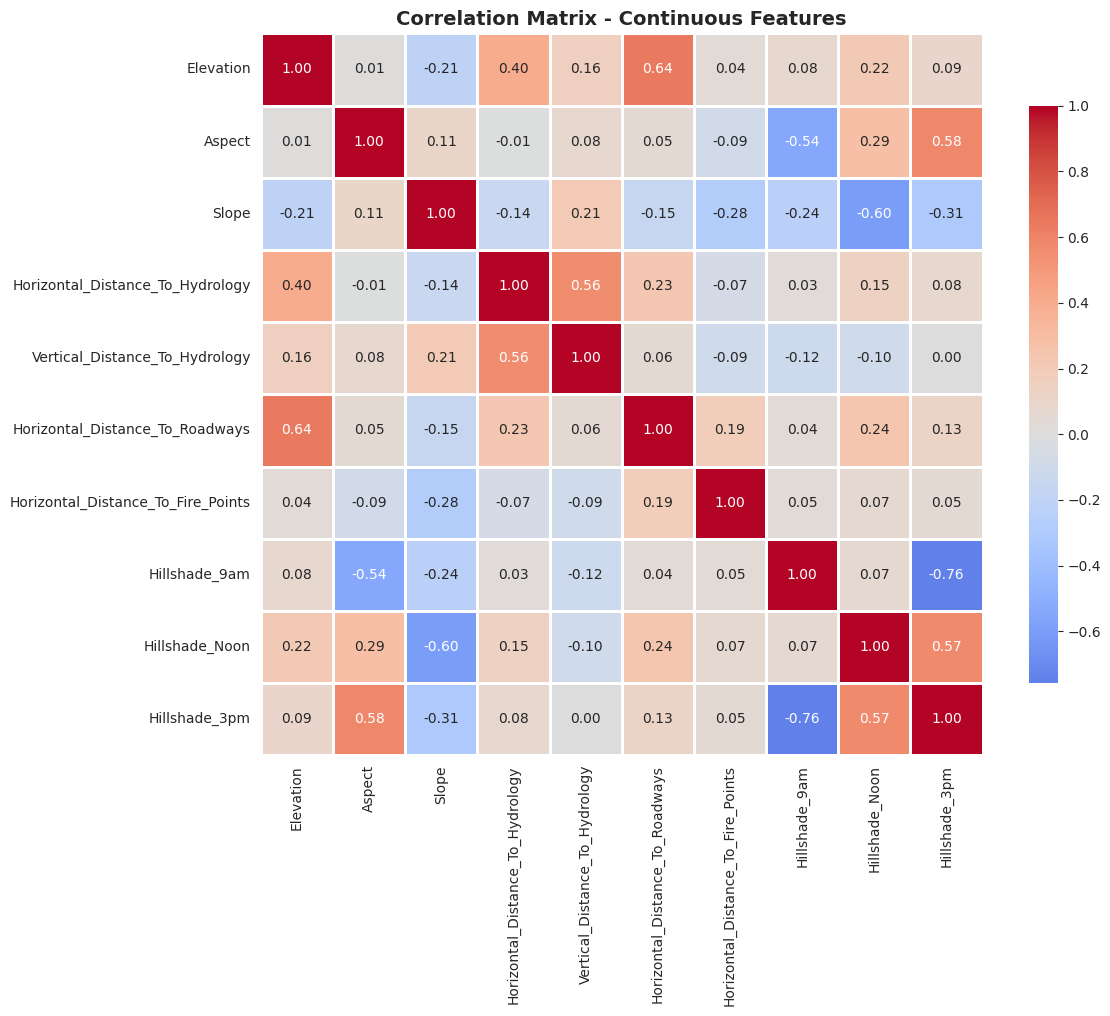


Highly correlated features (|r| > 0.7):
  Hillshade_9am <-> Hillshade_3pm: -0.757

=== FEATURES BY COVER TYPE ===


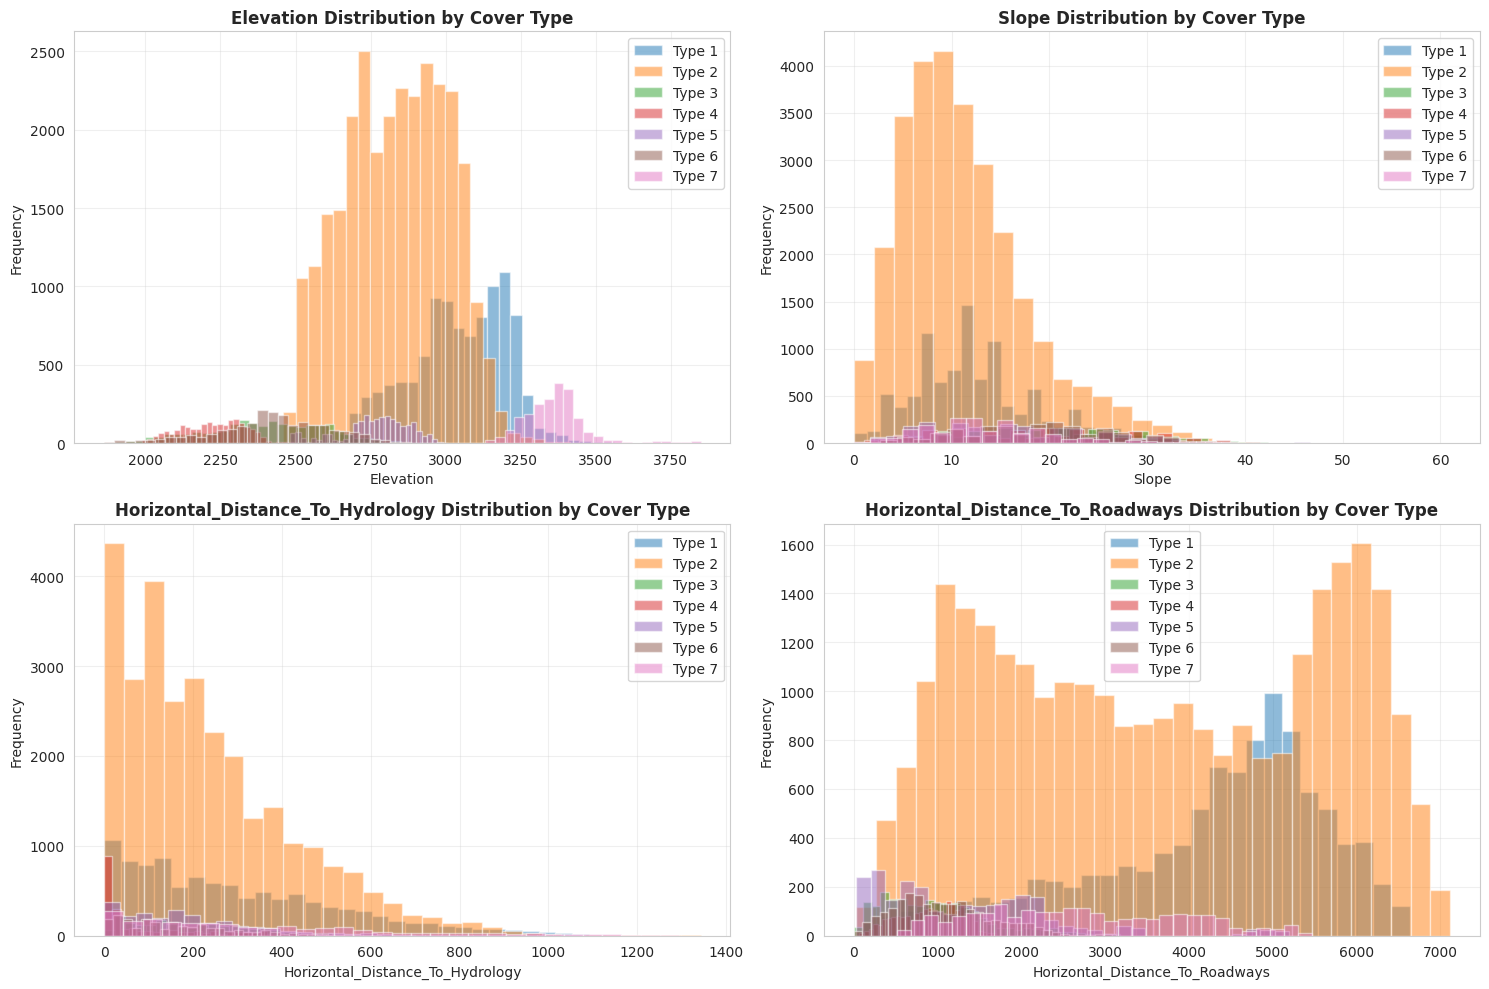

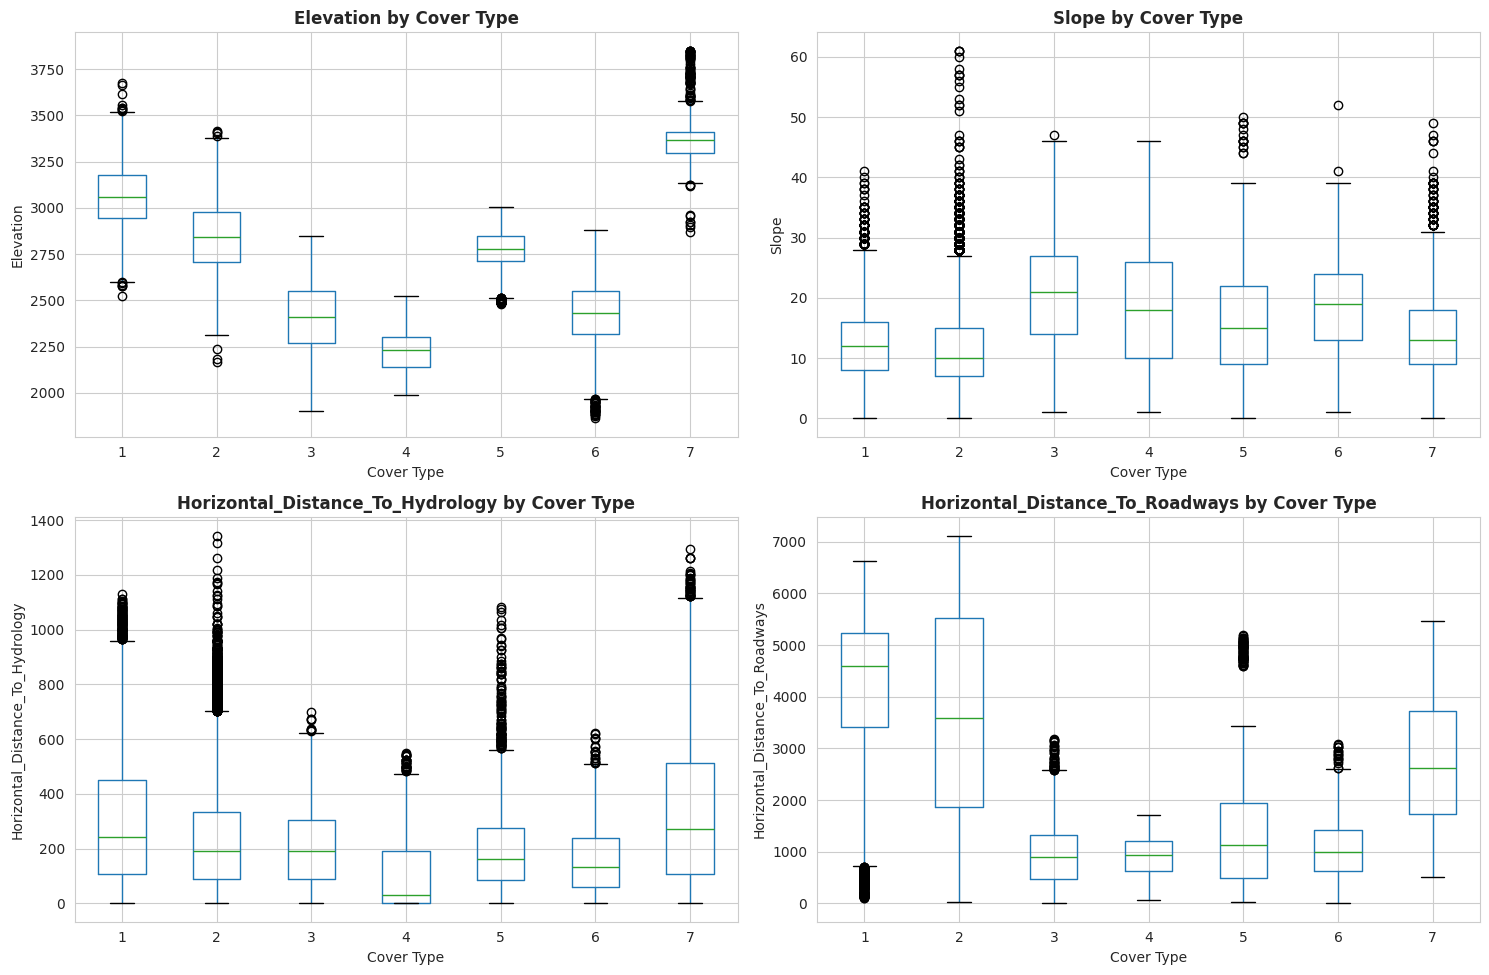


=== WILDERNESS AREA ANALYSIS ===
Samples per wilderness area:
Wilderness_Area1    38597
Wilderness_Area3     6349
Wilderness_Area4     4675
Wilderness_Area2      499
dtype: int64


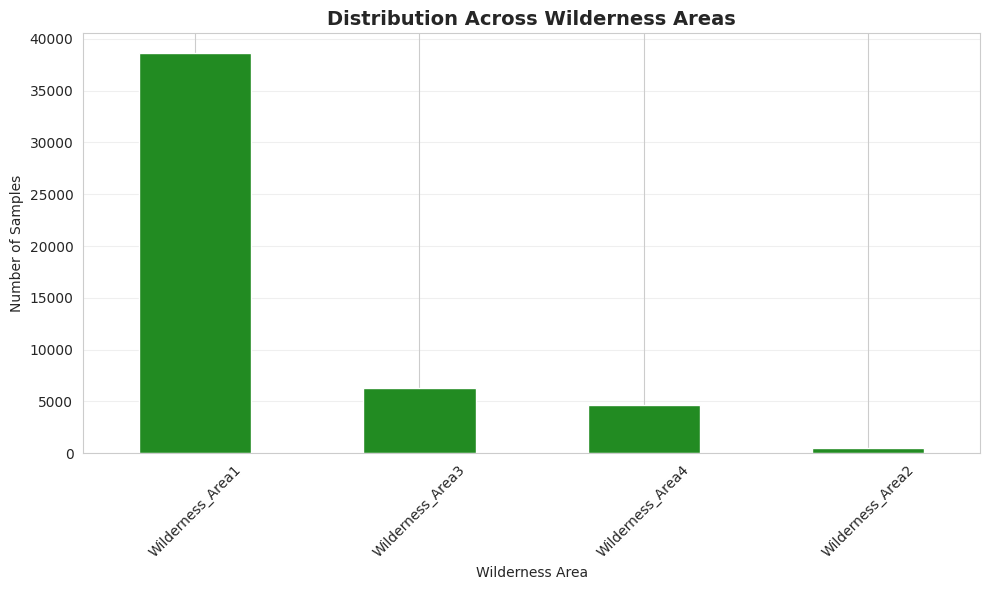


Cover types by wilderness area:
Cover_Type           1      2     3     4     5     6     7
row_0                                                      
Wilderness_Area1  9058  27882     0     0  1112     0   545
Wilderness_Area2   181     66     0     0     0     0   252
Wilderness_Area3   917    940   863     0  1304   962  1363
Wilderness_Area4     0     20  1297  2160     0  1198     0

=== SOIL TYPE ANALYSIS ===
Number of active soil types: 38

Top 10 most common soil types:
Soil_Type29    17333
Soil_Type12     8281
Soil_Type30     3694
Soil_Type20     2376
Soil_Type10     2142
Soil_Type23     1911
Soil_Type18     1812
Soil_Type24     1762
Soil_Type16     1097
Soil_Type3       962
dtype: int64


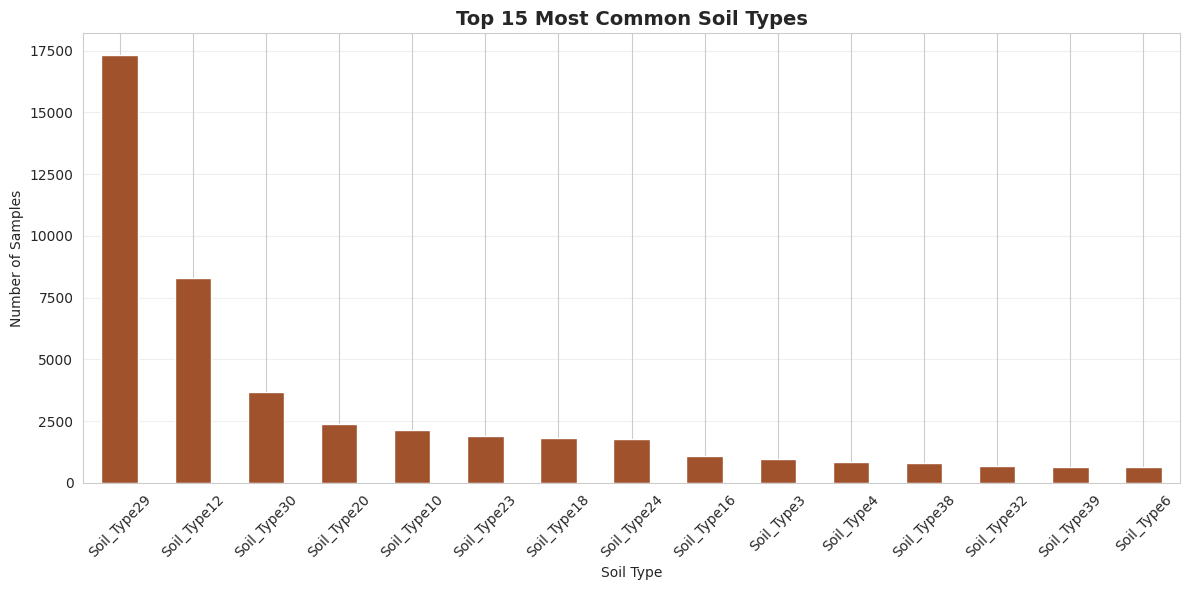


=== ASPECT ANALYSIS ===


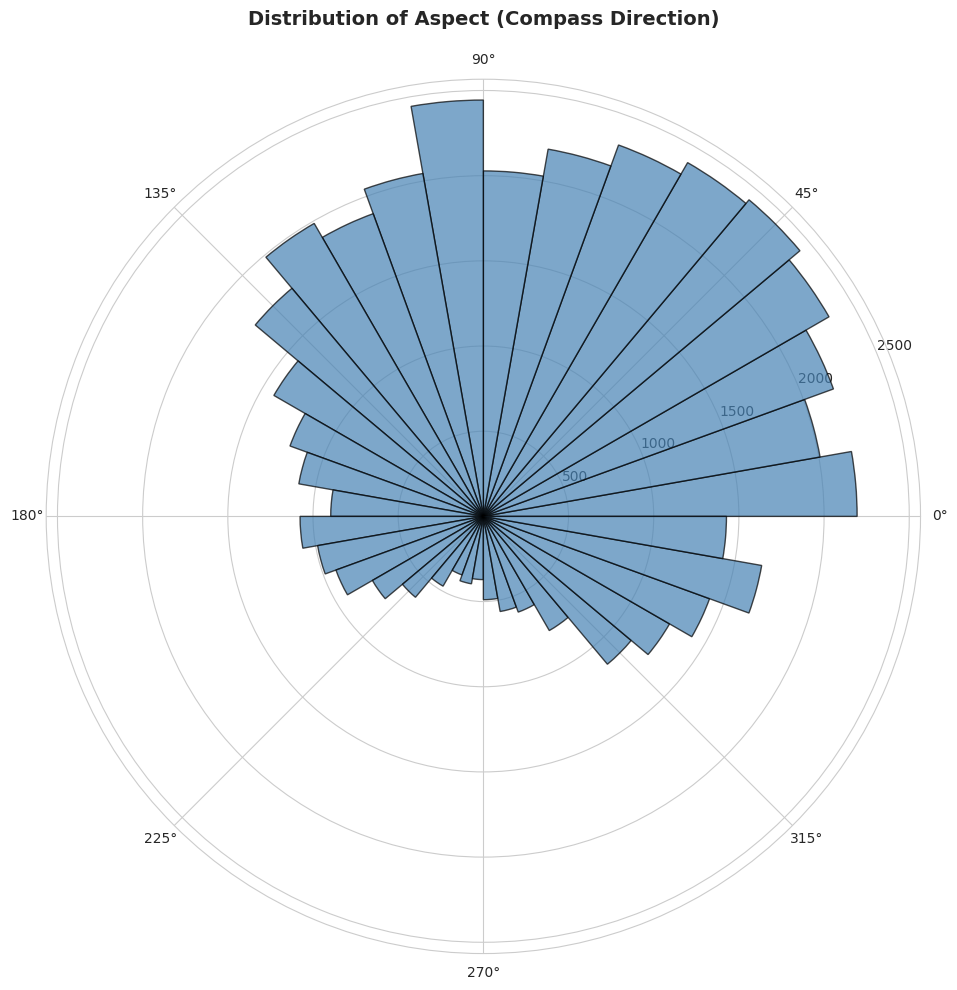

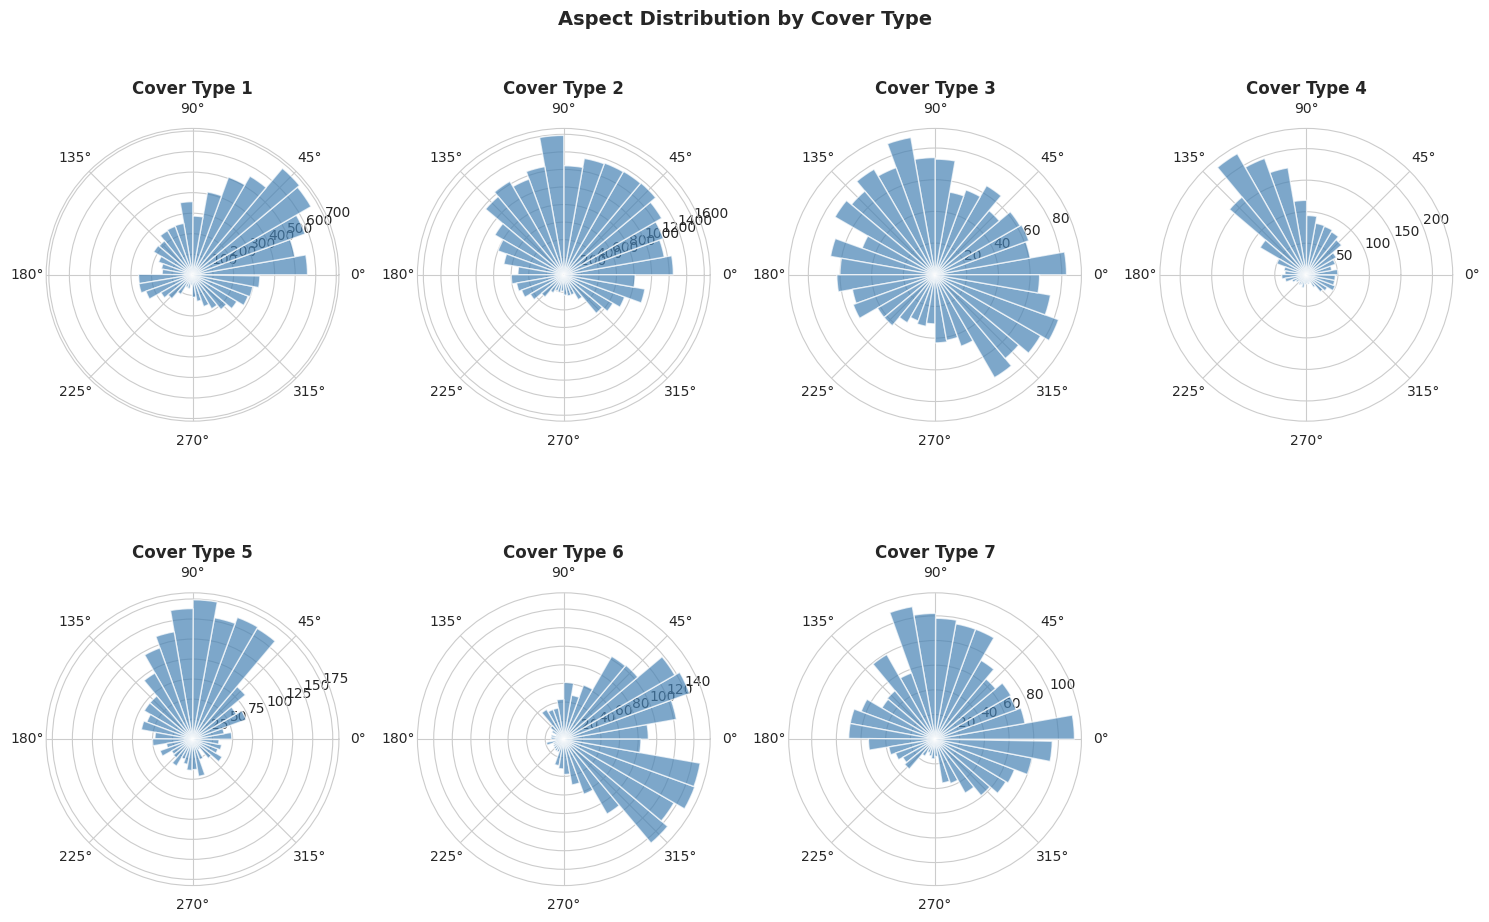


=== HILLSHADE ANALYSIS ===
Hillshade statistics:
       Hillshade_9am  Hillshade_Noon  Hillshade_3pm
count   50120.000000    50120.000000   50120.000000
mean      216.573524      223.459258     138.063168
std        24.340829       18.539704      35.162632
min         0.000000       99.000000       0.000000
25%       206.000000      215.000000     119.000000
50%       222.000000      226.000000     140.000000
75%       233.000000      236.000000     159.000000
max       254.000000      254.000000     248.000000


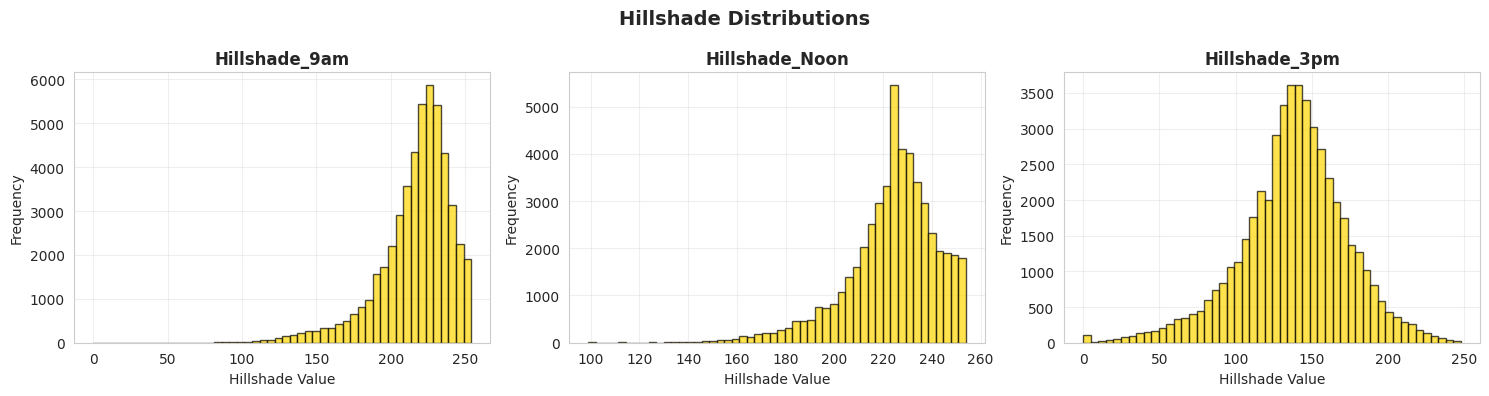


=== DISTANCE FEATURES ANALYSIS ===
Distance features statistics:
       Horizontal_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      50120.000000                     50120.000000   
mean                         241.725858                      3263.892598   
std                          206.101669                      1966.910482   
min                            0.000000                         0.000000   
25%                           85.000000                      1410.000000   
50%                          190.000000                      3127.000000   
75%                          350.000000                      5076.000000   
max                         1343.000000                      7117.000000   

       Horizontal_Distance_To_Fire_Points  
count                        50120.000000  
mean                          3548.404469  
std                           1927.352222  
min                              0.000000  
25%                          

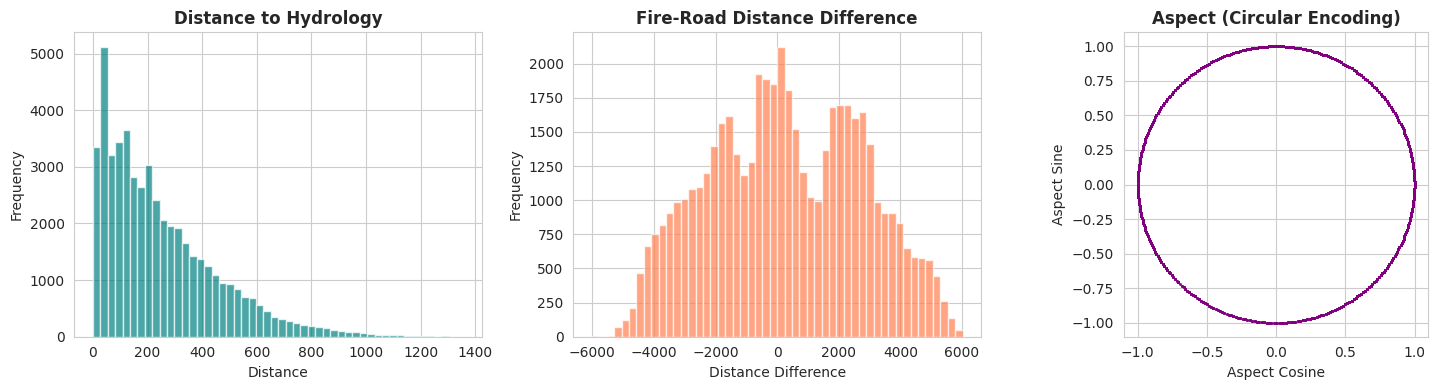


KEY INSIGHTS FROM EDA

1. DATA QUALITY:
   - No missing values: ✓
   - No duplicates: True
   - All features are numeric: ✓

2. TARGET VARIABLE:
   - Number of classes: 7
   - Class balance: 2160/28908 (min/max ratio)
   - WARNING: Significant class imbalance detected!
   - Consider: class weights, SMOTE, or stratified sampling

3. FEATURE CHARACTERISTICS:
   - Continuous features show varying scales
   - Scaling recommended for: SVM, KNN, Logistic Regression
   - No scaling needed for: Random Forest, Gradient Boosting

4. CORRELATIONS:
   - Found 1 highly correlated feature pairs
   - May benefit from dimensionality reduction

5. ENGINEERED FEATURES:
   - Distance_To_Hydrology: Combines horizontal and vertical distances
   - Fire_Road_Distance_Diff: Accessibility indicator
   - Aspect_Sin/Cos: Proper encoding of circular feature
   - Additional features in preprocessing script

6. RECOMMENDATIONS:
   - Use stratified cross-validation due to class distribution
   - Try ensemble method

In [1]:
# Forest Cover Type Classification - Exploratory Data Analysis
# This notebook provides a starting point for EDA

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# %% Load Data
print("Loading data...")
df_train = pd.read_csv('../data/train.csv')
print(f"Dataset shape: {df_train.shape}")
print(f"\nFirst few rows:")
df_train.head()

# %% Basic Information
print("\n=== DATASET INFORMATION ===")
print(f"Number of samples: {len(df_train)}")
print(f"Number of features: {df_train.shape[1] - 1}")  # Excluding target
print(f"Target variable: Cover_Type")
print(f"\nData types:\n{df_train.dtypes.value_counts()}")
print(f"\nMemory usage: {df_train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# %% Missing Values
print("\n=== MISSING VALUES ===")
missing = df_train.isnull().sum()
if missing.sum() == 0:
    print("✓ No missing values detected")
else:
    print(missing[missing > 0])

# %% Target Variable Distribution
print("\n=== TARGET VARIABLE DISTRIBUTION ===")
target_counts = df_train['Cover_Type'].value_counts().sort_index()
print(target_counts)
print(f"\nClass balance:")
print((target_counts / len(df_train) * 100).round(2))

# Plot target distribution
plt.figure(figsize=(10, 6))
target_counts.plot(kind='bar', color='steelblue')
plt.title('Distribution of Forest Cover Types', fontsize=14, fontweight='bold')
plt.xlabel('Cover Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# %% Feature Groups
print("\n=== FEATURE GROUPS ===")

# Identify feature types
continuous_features = [
    'Elevation', 'Aspect', 'Slope',
    'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'
]

wilderness_features = [col for col in df_train.columns if 'Wilderness_Area' in col]
soil_features = [col for col in df_train.columns if 'Soil_Type' in col]

print(f"Continuous features: {len(continuous_features)}")
print(f"Wilderness area features: {len(wilderness_features)}")
print(f"Soil type features: {len(soil_features)}")

# %% Continuous Features - Summary Statistics
print("\n=== CONTINUOUS FEATURES SUMMARY ===")
df_train[continuous_features].describe()

# %% Continuous Features - Distributions
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.ravel()

for idx, col in enumerate(continuous_features):
    axes[idx].hist(df_train[col], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].set_title(col, fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('Frequency')
    
plt.suptitle('Distribution of Continuous Features', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# %% Correlation Analysis
print("\n=== CORRELATION ANALYSIS ===")
correlation_matrix = df_train[continuous_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Continuous Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# High correlations
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

if high_corr:
    print("\nHighly correlated features (|r| > 0.7):")
    for feat1, feat2, corr in high_corr:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("\nNo highly correlated features found (|r| > 0.7)")

# %% Feature Distributions by Cover Type
print("\n=== FEATURES BY COVER TYPE ===")

# Select top features to visualize
features_to_plot = ['Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology', 
                    'Horizontal_Distance_To_Roadways']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(features_to_plot):
    for cover_type in sorted(df_train['Cover_Type'].unique()):
        data = df_train[df_train['Cover_Type'] == cover_type][feature]
        axes[idx].hist(data, bins=30, alpha=0.5, label=f'Type {cover_type}')
    
    axes[idx].set_title(f'{feature} Distribution by Cover Type', fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# %% Box Plots for Key Features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(features_to_plot):
    df_train.boxplot(column=feature, by='Cover_Type', ax=axes[idx])
    axes[idx].set_title(f'{feature} by Cover Type', fontweight='bold')
    axes[idx].set_xlabel('Cover Type')
    axes[idx].set_ylabel(feature)
    plt.sca(axes[idx])
    plt.xticks(rotation=0)

plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

# %% Wilderness Area Analysis
print("\n=== WILDERNESS AREA ANALYSIS ===")
wilderness_counts = df_train[wilderness_features].sum().sort_values(ascending=False)
print("Samples per wilderness area:")
print(wilderness_counts)

plt.figure(figsize=(10, 6))
wilderness_counts.plot(kind='bar', color='forestgreen')
plt.title('Distribution Across Wilderness Areas', fontsize=14, fontweight='bold')
plt.xlabel('Wilderness Area')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Cover types by wilderness area
wilderness_cover = pd.crosstab(
    df_train[wilderness_features].idxmax(axis=1),
    df_train['Cover_Type']
)
print("\nCover types by wilderness area:")
print(wilderness_cover)

# %% Soil Type Analysis
print("\n=== SOIL TYPE ANALYSIS ===")
soil_counts = df_train[soil_features].sum().sort_values(ascending=False)
print(f"Number of active soil types: {(soil_counts > 0).sum()}")
print(f"\nTop 10 most common soil types:")
print(soil_counts.head(10))

# Plot top 15 soil types
plt.figure(figsize=(12, 6))
soil_counts.head(15).plot(kind='bar', color='sienna')
plt.title('Top 15 Most Common Soil Types', fontsize=14, fontweight='bold')
plt.xlabel('Soil Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# %% Aspect Analysis (Circular Feature)
print("\n=== ASPECT ANALYSIS ===")

# Convert aspect to radians for circular plotting
aspect_rad = df_train['Aspect'] * np.pi / 180

plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')
ax.hist(aspect_rad, bins=36, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_title('Distribution of Aspect (Compass Direction)', 
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Aspect by cover type
fig = plt.figure(figsize=(15, 10))
for i, cover_type in enumerate(sorted(df_train['Cover_Type'].unique()), 1):
    ax = plt.subplot(2, 4, i, projection='polar')
    data = df_train[df_train['Cover_Type'] == cover_type]['Aspect'] * np.pi / 180
    ax.hist(data, bins=36, color='steelblue', alpha=0.7)
    ax.set_title(f'Cover Type {cover_type}', fontweight='bold')
plt.suptitle('Aspect Distribution by Cover Type', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# %% Hillshade Analysis
print("\n=== HILLSHADE ANALYSIS ===")

hillshade_features = ['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']
hillshade_data = df_train[hillshade_features]

# Mean hillshade
df_train['Mean_Hillshade'] = hillshade_data.mean(axis=1)

# Hillshade variance
df_train['Hillshade_Variance'] = hillshade_data.var(axis=1)

print("Hillshade statistics:")
print(hillshade_data.describe())

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, col in enumerate(hillshade_features):
    axes[idx].hist(df_train[col], bins=50, color='gold', alpha=0.7, edgecolor='black')
    axes[idx].set_title(col, fontweight='bold')
    axes[idx].set_xlabel('Hillshade Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

plt.suptitle('Hillshade Distributions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# %% Distance Features Analysis
print("\n=== DISTANCE FEATURES ANALYSIS ===")

distance_features = [
    'Horizontal_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Horizontal_Distance_To_Fire_Points'
]

print("Distance features statistics:")
print(df_train[distance_features].describe())

# Check for outliers using IQR method
for feature in distance_features:
    Q1 = df_train[feature].quantile(0.25)
    Q3 = df_train[feature].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df_train[feature] < (Q1 - 1.5 * IQR)) | 
                (df_train[feature] > (Q3 + 1.5 * IQR))).sum()
    print(f"{feature}: {outliers} outliers ({outliers/len(df_train)*100:.2f}%)")

# %% Proposed Engineered Features - Preview
print("\n=== PROPOSED ENGINEERED FEATURES ===")

# 1. Euclidean distance to hydrology
df_train['Distance_To_Hydrology'] = np.sqrt(
    df_train['Horizontal_Distance_To_Hydrology']**2 + 
    df_train['Vertical_Distance_To_Hydrology']**2
)
print("✓ Distance_To_Hydrology created")

# 2. Fire-Road distance difference
df_train['Fire_Road_Distance_Diff'] = (
    df_train['Horizontal_Distance_To_Fire_Points'] - 
    df_train['Horizontal_Distance_To_Roadways']
)
print("✓ Fire_Road_Distance_Diff created")

# 3. Aspect sine and cosine
aspect_rad = df_train['Aspect'] * np.pi / 180
df_train['Aspect_Sin'] = np.sin(aspect_rad)
df_train['Aspect_Cos'] = np.cos(aspect_rad)
print("✓ Aspect_Sin and Aspect_Cos created")

# Visualize engineered features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df_train['Distance_To_Hydrology'], bins=50, color='teal', alpha=0.7)
axes[0].set_title('Distance to Hydrology', fontweight='bold')
axes[0].set_xlabel('Distance')
axes[0].set_ylabel('Frequency')

axes[1].hist(df_train['Fire_Road_Distance_Diff'], bins=50, color='coral', alpha=0.7)
axes[1].set_title('Fire-Road Distance Difference', fontweight='bold')
axes[1].set_xlabel('Distance Difference')
axes[1].set_ylabel('Frequency')

axes[2].scatter(df_train['Aspect_Cos'], df_train['Aspect_Sin'], 
                alpha=0.1, s=1, color='purple')
axes[2].set_title('Aspect (Circular Encoding)', fontweight='bold')
axes[2].set_xlabel('Aspect Cosine')
axes[2].set_ylabel('Aspect Sine')
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()

# %% Key Insights Summary
print("\n" + "="*70)
print("KEY INSIGHTS FROM EDA")
print("="*70)

print("\n1. DATA QUALITY:")
print(f"   - No missing values: ✓")
print(f"   - No duplicates: {df_train.duplicated().sum() == 0}")
print(f"   - All features are numeric: ✓")

print("\n2. TARGET VARIABLE:")
print(f"   - Number of classes: {df_train['Cover_Type'].nunique()}")
print(f"   - Class balance: {target_counts.min()}/{target_counts.max()} (min/max ratio)")
if target_counts.max() / target_counts.min() > 3:
    print("   - WARNING: Significant class imbalance detected!")
    print("   - Consider: class weights, SMOTE, or stratified sampling")

print("\n3. FEATURE CHARACTERISTICS:")
print(f"   - Continuous features show varying scales")
print(f"   - Scaling recommended for: SVM, KNN, Logistic Regression")
print(f"   - No scaling needed for: Random Forest, Gradient Boosting")

print("\n4. CORRELATIONS:")
if high_corr:
    print(f"   - Found {len(high_corr)} highly correlated feature pairs")
    print("   - May benefit from dimensionality reduction")
else:
    print("   - No highly correlated features detected")

print("\n5. ENGINEERED FEATURES:")
print("   - Distance_To_Hydrology: Combines horizontal and vertical distances")
print("   - Fire_Road_Distance_Diff: Accessibility indicator")
print("   - Aspect_Sin/Cos: Proper encoding of circular feature")
print("   - Additional features in preprocessing script")

print("\n6. RECOMMENDATIONS:")
print("   - Use stratified cross-validation due to class distribution")
print("   - Try ensemble methods (Random Forest, Gradient Boosting)")
print("   - Feature importance analysis after initial modeling")
print("   - Monitor for overfitting (train vs. validation accuracy)")

print("\n" + "="*70)
print("EDA COMPLETE - Ready for Model Selection")
print("="*70)